# Using Regression to Predict Total Points of 2025 NHL Players

In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import TopDownHockey_Scraper.TopDownHockey_EliteProspects_Scraper as tdhepscrape
from unidecode import unidecode

In [603]:
league = 'nhl'
season = "2024-2025"
nhl_2025 = tdhepscrape.get_skaters(league, season)

Your scrape request is skater data from the following league:
nhl
In the following season:
2024-2025
Beginning scrape of nhl skater data from 2024-2025.
Successfully scraped all nhl skater data from 2024-2025.
Scraping nhl data is complete. You scraped skater data from 2024-2025.
Completed scraping skater data from the following league:
nhl
Over the following season:
2024-2025


In [604]:
## Check for missing values
missing_values = nhl_2025.isna().sum()
print(missing_values)
# Replace all - with Zero
nhl_2025 = nhl_2025.replace('-', 0)

player        0
team          0
gp            0
g             0
a             0
tp            0
ppg           0
pim           0
+/-           0
link          0
season        0
league        0
playername    0
position      0
dtype: int64


In [605]:
#Removing extra spaces from 'playername' and column names
nhl_2025['playername'] = nhl_2025['playername'].str.strip()
nhl_2025.columns = nhl_2025.columns.str.strip()
#Redundant to have a 'player' and 'playername' column, drop 'positon' and 'player'
nhl_2025 = nhl_2025.drop(['player', 'position'], axis = 1)

In [606]:
# extract position(s) from the 'playername' column
nhl_2025['position'] = nhl_2025['playername'].str.extract(r'\((.*?)\)')
nhl_2025['playername'] = nhl_2025['playername'].str.replace(r'\(.*?\)', '', regex=True)
nhl_2025[['position1','position2']] = nhl_2025['position'].str.split('/', expand=True)
# replace missing second positions with duplicate first positions
nhl_2025['position2'].fillna(nhl_2025['position1'], inplace=True)
nhl_2025 = nhl_2025.drop(['position'], axis = 1)

In [607]:
# Removes non-ASCII characters
nhl_2025 = nhl_2025.applymap(lambda x: unidecode(x) if isinstance(x,str) else x)
nhl_2025.drop(columns=['league', 'season', 'link'])
nhl_2025 = nhl_2025[['playername', 'position1', 'position2', 'team', 'gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-', 'link']]
# Store player names seperately 
player_names = nhl_2025[['playername']]

In [608]:
# Replace 'totals' with dictionary stated values
trade_roster = {
    "Seth Jones": "Florida Panthers",
    "Trent Frederic": "Edmonton Oilers",
    "Vitek Vanecek": "Florida Panthers",
    "Oliver Bjorkstrand": "Tampa Bay Lightning",
    "Yanni Gourde": "Tampa Bay Lightning",
    "Michael Bunting": "Nashville Predators",
    "Brian Dumoulin": "New Jersey Devils",
    "Nico Sturm": "Florida Panthers",
    "Chris Driedger": "Winnipeg Jets",
    "Reilly Smith": "Vegas Golden Knights",
    "Carson Soucy": "New York Rangers",
    "Brock Nelson": "Colorado Avalanche",
    "Jake Walman": "Edmonton Oilers",
    "Anthony Beauvillier": "Washington Capitals",
    "Andrei Kuzmenko": "Los Angeles Kings",
    "Dylan Cozens": "Ottawa Senators",
    "Scott Laughton": "Toronto Maple Leafs",
    "Mikko Rantanen": "Dallas Stars",
    "Charlie Coyle": "Colorado Avalanche",
    "Petr Mrazek": "Detroit Red Wings",
    "Craig Smith": "Detroit Red Wings",
    "Luke Kunin": "Columbus Blue Jackets",
    "Fabian Zetterlund": "Ottawa Senators",
    "Erik Johnson": "Colorado Avalanche",
    "Erik Brannstrom": "Buffalo Sabres",
    "Dennis Cholowski": "New Jersey Devils",
    "Brad Marchand": "Florida Panthers",
    "Cody Glass": "New Jersey Devils",
    "Mark Jankowski": "Carolina Hurricanes",
    "Daniel Sprong": "New Jersey Devils",
    "Henri Jokiharju": "Boston Bruins",
    "Daniil Misyul": "Boston Bruins",
    "Marc McLaughlin": "New Jersey Devils",
    "Connor Dewar": "Pittsburgh Penguins",
    "Conor Timmins": "Pittsburgh Penguins",
    "Brandon Carlo": "Toronto Maple Leafs",
    "Erik Haula": "New Jersey Devils",
    "Tyler Bertuzzi": "Chicago Blackhawks",
    "Sam Carrick": "New York Rangers",
    "Brandon Montour": "Seattle Kraken",
    "Tyler Toffoli": "San Jose Sharks",
    "Sam Lafferty": "Buffalo Sabres",
    "Jonathan Marchessault": "Nashville Predators",
    "Noel Acciari": "Ottawa Senators",
    "Alec Martinez": "Chicago Blackhawks",
    "Anthony Mantha": "Calgary Flames",
    "Brett Pesce": "New Jersey Devils",
    "Mac Hollowell": "Pittsburgh Penguins",
    "Matt Roy": "Washington Capitals",
    "Oliver Ekman-Larsson": "Toronto Maple Leafs",
    "Jordan Frasca": "Nashville Predators",
    "Vasily Podkolzin": "Edmonton Oilers",
    "Ty Emberson": "Edmonton Oilers",
    "Jordan Harris": "Columbus Blue Jackets",
    "Paul Fischer": "Edmonton Oilers",
    "Rutger McGroarty": "Pittsburgh Penguins",
    "Magnus Chrona": "Nashville Predators",
    "David Edstrom": "Nashville Predators",
    "Tucker Poolman": "Colorado Avalanche",
    "Olli Maatta": "Utah Hockey Club",
    "Timothy Liljegren": "San Jose Sharks",
    "Lucas Edmonds": "New York Rangers",
    "Scott Perunovich": "New York Islanders",
    "Joel Farabee": "Calgary Flames",
    "Morgan Frost": "Calgary Flames",
    "J.T. Miller": "New York Rangers",
    "Vincent Desharnais": "Vancouver Canucks",
    "Danton Heinen": "Vancouver Canucks",
    "Marcus Pettersson": "Vancouver Canucks",
    "Drew O'Connor": "Vancouver Canucks"
}
mask = nhl_2025['team'].str.lower() == 'totals'
nhl_2025.loc[mask, 'team'] = nhl_2025.loc[mask, 'playername'].map(trade_roster)

In [609]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
categorical_features = ['team', 'position1', 'position2']
numerical_features = ['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']
# create a columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, drop='if_binary'), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

# apply transformations
nhl_transformed = preprocessor.fit_transform(nhl_2025)

# get names of one-hot encoded columns
ohe_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features)
# get names of remaining columns - combine remaining & one-hot encoded column names
remaining_feature_names = numerical_features + [col for col in nhl_2025.columns if col not in categorical_features + numerical_features]
all_column_names = list(ohe_feature_names) + remaining_feature_names
# convert transformed array 
nhl_final_df = pd.DataFrame(nhl_transformed, columns=all_column_names)

print(f"Number of transformed columns: {len(all_column_names)}")
print(f"Transformed column names: {all_column_names}")

Number of transformed columns: 54
Transformed column names: ['team_Anaheim Ducks', 'team_Boston Bruins', 'team_Buffalo Sabres', 'team_Calgary Flames', 'team_Carolina Hurricanes', 'team_Chicago Blackhawks', 'team_Colorado Avalanche', 'team_Columbus Blue Jackets', 'team_Dallas Stars', 'team_Detroit Red Wings', 'team_Edmonton Oilers', 'team_Florida Panthers', 'team_Los Angeles Kings', 'team_Minnesota Wild', 'team_Montreal Canadiens', 'team_Nashville Predators', 'team_New Jersey Devils', 'team_New York Islanders', 'team_New York Rangers', 'team_Ottawa Senators', 'team_Philadelphia Flyers', 'team_Pittsburgh Penguins', 'team_San Jose Sharks', 'team_Seattle Kraken', 'team_St. Louis Blues', 'team_Tampa Bay Lightning', 'team_Toronto Maple Leafs', 'team_Utah Hockey Club', 'team_Vancouver Canucks', 'team_Vegas Golden Knights', 'team_Washington Capitals', 'team_Winnipeg Jets', 'team_nan', 'position1_C', 'position1_D', 'position1_F', 'position1_LW', 'position1_RW', 'position1_W', 'position2_C', 'po

In [610]:
nhl_final_df.to_csv('nhl_final_df.csv', index=False)

## Exploratory Data Analysis

In [621]:
# Explore the performance stats: gp, g, a, tp, ppg, pim, +/-
nhl_final_df[['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']].describe()


,gp,g,a,tp,ppg,pim,+/-
count,904.000000,904.000000,904.000000,904.000000,904.000000,904.000000,904.000000
unique,77.000000,41.000000,62.000000,88.000000,119.000000,84.000000,72.000000
top,0.983686,-0.876247,-0.982878,-0.996877,-1.223664,-1.031831,0.049031
freq,97.000000,193.000000,143.000000,117.000000,117.000000,120.000000,97.000000


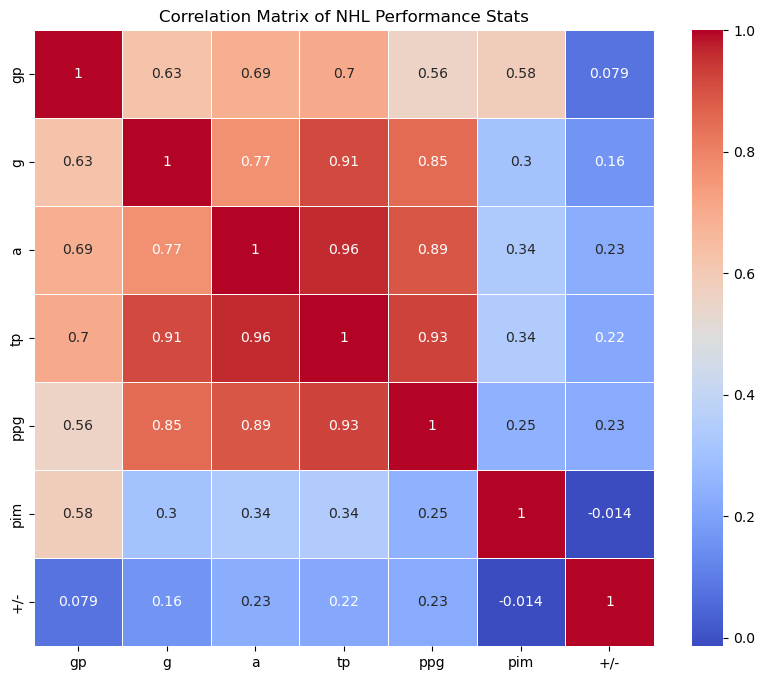

In [612]:
# Explore the performance stats: gp, g, a, tp, ppg, pim, +/-
nhl_final_df[['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']].describe()
# Check for null values
nhl_final_df[['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']].isnull().sum()
# Correlation matrix for the performance stats
# gp, g, a, tp, ppg, pim, +/-
# Correlation and Show
performance_corr = nhl_final_df[['gp', 'g', 'a', 'tp', 'ppg', 'pim', '+/-']].corr()
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(performance_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of NHL Performance Stats')
plt.show()

Total points correlates most with goals, assists, and points per game. This makes sense because goals and assists contribute to the total point value, while point per game is a metric from tp and gp that expresses an average production expected by a player for each game. In other words, it is a way to measure performance relative to number of games played.

In [613]:
# On average there should be ~30-40 unique rows in the encoded teams columns
nhl_final_df['team_Anaheim Ducks'].value_counts()
nhl_final_df['team_Boston Bruins'].value_counts()
nhl_final_df['team_Buffalo Sabres'].value_counts()
nhl_final_df['team_Carolina Hurricanes'].value_counts()
nhl_final_df['team_Columbus Blue Jackets'].value_counts()
nhl_final_df['team_Colorado Avalanche'].value_counts()
nhl_final_df['team_Detroit Red Wings'].value_counts()
nhl_final_df['team_Edmonton Oilers'].value_counts()
nhl_final_df['team_Florida Panthers'].value_counts()
nhl_final_df['team_Los Angeles Kings'].value_counts()
nhl_final_df['team_Montreal Canadiens'].value_counts()
nhl_final_df['team_Nashville Predators'].value_counts()
nhl_final_df['team_New Jersey Devils'].value_counts()
# etc.. I could keep going but for the sake of brevity


team_New Jersey Devils
0.0    875
1.0     29
Name: count, dtype: int64

In [614]:
nhl_final_df

,team_Anaheim Ducks,team_Boston Bruins,team_Buffalo Sabres,team_Calgary Flames,team_Carolina Hurricanes,team_Chicago Blackhawks,team_Colorado Avalanche,team_Columbus Blue Jackets,team_Dallas Stars,team_Detroit Red Wings,...,position2_W,gp,g,a,tp,ppg,pim,+/-,playername,link
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.833341,2.822665,4.689809,4.180934,4.211831,1.119958,2.021058,Nikita Kucherov,https://www.eliteprospects.com/player/77237/ni...
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.021273,2.4864,4.91373,4.180934,3.833411,0.919791,2.584494,Nathan MacKinnon,https://www.eliteprospects.com/player/99204/na...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.833341,4.840254,2.973074,3.943419,3.971018,0.669583,3.14793,Leon Draisaitl,https://www.eliteprospects.com/player/71913/le...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.9461,2.150135,3.943402,3.420888,3.214177,-0.731582,3.335742,Jack Eichel,https://www.eliteprospects.com/player/191959/j...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.983686,1.701782,4.092684,3.325882,3.076569,-0.331249,0.988091,Mitchell Marner,https://www.eliteprospects.com/player/223194/m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.760108,-0.876247,-0.982878,-0.996877,-1.223664,-1.031831,0.049031,Karsen Dorwart,https://www.eliteprospects.com/player/561422/k...
900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,-1.760108,-0.876247,-0.982878,-0.996877,-1.223664,-1.031831,0.049031,Christian Kyrou,https://www.eliteprospects.com/player/582653/c...
901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.760108,-0.876247,-0.982878,-0.996877,-1.223664,-1.031831,0.049031,Ryan Leonard,https://www.eliteprospects.com/player/603021/r...
902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.760108,-0.876247,-0.982878,-0.996877,-1.223664,-1.031831,0.049031,Matthew Wood,https://www.eliteprospects.com/player/603587/m...


## Experiment 1 : Linear Regression


In [615]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error,mean_absolute_error, r2_score

In [616]:
#Create and train linear regression model using sklearn
#Identify the target variable
nhl_final_df = nhl_final_df.drop(columns=['playername', 'link'])
X = nhl_final_df.drop(columns=["tp"])
y = nhl_final_df["tp"]
# Split the numeric data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [617]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print the Test and Train evaluation metrics
print(f"EXPERIMENT ONE RESULTS :\nMean Absolute Error: {mae:.10f}")
print(f"Mean Squared Error: {mse:.10f}")
print(f"R-squared: {r2:.10f}")


EXPERIMENT ONE RESULTS :
Mean Absolute Error: 0.0000000000
Mean Squared Error: 0.0000000000
R-squared: 1.0000000000


Understandable output considering that our numerical features are all continuous and linearly related to the target variable. Particularly, goals and assists added together is the total point value. It could be useful to drop those as they are so closely related to the target variable. 

## Experiment 2 

In [618]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Pre
X = nhl_final_df.drop(columns=["tp", "a", "g"])
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model with new feature sets
linear = LinearRegression()
linear.fit(X_train, y_train)

# Make predictions
y_pred_train = linear.predict(X_train)
y_pred_test = linear.predict(X_test)

# Evaluate performance
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print results
print(f'EXPERIMENT TWO RESULTS (TRAIN):\nMean Absolute Error: {mae_train:.10f}')
print(f'Mean Squared Error: {mse_train:.10f}')
print(f'R-squared: {r2_train:.10f}\n')

print(f'EXPERIMENT TWO RESULTS (TEST):\nMean Absolute Error: {mae_test:.10f}')
print(f'Mean Squared Error: {mse_test:.10f}')
print(f'R-squared: {r2_test:.10f}')

EXPERIMENT TWO RESULTS (TRAIN):
Mean Absolute Error: 0.2048144970
Mean Squared Error: 0.0869312765
R-squared: 0.9143178742

EXPERIMENT TWO RESULTS (TEST):
Mean Absolute Error: 0.2108853537
Mean Squared Error: 0.0739613008
R-squared: 0.9214515673


In [619]:
from sklearn.linear_model import Ridge
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Increase the test size

# Train Ridge Regression model 
ridge = Ridge(alpha=1)  
ridge.fit(X_train, y_train)

# Make predictions
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Evaluate performance
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print results
print(f'EXPERIMENT THREE RESULTS (TRAIN):\nMean Absolute Error: {mae_train:.10f}')
print(f'Mean Squared Error: {mse_train:.10f}')
print(f'R-squared: {r2_train:.10f}\n')

print(f'EXPERIMENT THREE RESULTS (TEST):\nMean Absolute Error: {mae_test:.10f}')
print(f'Mean Squared Error: {mse_test:.10f}')
print(f'R-squared: {r2_test:.10f}')

EXPERIMENT THREE RESULTS (TRAIN):
Mean Absolute Error: 0.2050271021
Mean Squared Error: 0.0867711881
R-squared: 0.9144756623

EXPERIMENT THREE RESULTS (TEST):
Mean Absolute Error: 0.2091964709
Mean Squared Error: 0.0733239763
R-squared: 0.9221284190


In [620]:
# Experiment Four
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
ridge = Ridge(alpha=1)  
ridge.fit(X_train, y_train)

# Make predictions
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Evaluate performance
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print results
print(f'EXPERIMENT FOUR RESULTS (TRAIN):\nMean Absolute Error: {mae_train:.10f}')
print(f'Mean Squared Error: {mse_train:.10f}')
print(f'R-squared: {r2_train:.10f}\n')

print(f'EXPERIMENT FOUR RESULTS (TEST):\nMean Absolute Error: {mae_test:.10f}')
print(f'Mean Squared Error: {mse_test:.10f}')
print(f'R-squared: {r2_test:.10f}')

EXPERIMENT FOUR RESULTS (TRAIN):
Mean Absolute Error: 0.2050271021
Mean Squared Error: 0.0867711881
R-squared: 0.9144756623

EXPERIMENT FOUR RESULTS (TEST):
Mean Absolute Error: 0.2091964709
Mean Squared Error: 0.0733239763
R-squared: 0.9221284190
